In [172]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter

import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent DataFrame output from wrapping to the next line
pd.options.display.float_format = '{:,.2f}'.format

In [173]:
train_weather = pd.read_parquet('/app/data/train_with_weather_cleaned_20240514.parquet', engine='fastparquet')
test_weather = pd.read_parquet('/app/data/test_with_weather_cleaned_20240514.parquet', engine='fastparquet')

# Drop 'Date' from both train and test datasets
train_weather = train_weather.drop('Date', axis=1)
test_weather = test_weather.drop('Date', axis=1)

# Separate the target variable
X_train = train_weather.drop('WnvPresent', axis=1)
y_train = train_weather['WnvPresent']

In [174]:
# Split training data into training and validation
X_train_o, X_val_o, y_train_o, y_val_o = train_test_split(X_train, y_train, test_size=.3)

# Ensures each fold is representative of the overall class distribution
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

default_models = {
    'RandomForestClassifier':RandomForestClassifier(), 
    'XGBClassifier': xgb.XGBClassifier(), 
    'LogisticRegression': make_pipeline(StandardScaler(), LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=1.0, solver='saga', max_iter=1000)),
    'GaussianNB': GaussianNB(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(algorithm='SAMME')
}

In [169]:
### TEST 6 MODELS WITH DEFAULT HYPERPARAMETERS USING CLEANED DATA (1:0.05) ###

best_model_o = {
    'name': 'RandomForestClassifier',
    'model': RandomForestClassifier(),
    'score': 0.0
}

for name, dm in default_models.items():
    scores = cross_val_score(dm, X_train_o, y_train_o, cv=cv, scoring='roc_auc')

    score_mean = np.mean(scores)
    score_var = np.std(scores)

    if score_mean > best_model_o['score']: 
        best_model_o['name'] = name
        best_model_o['model'] = dm
        best_model_o['score'] = score_mean
    
    # Cross-validation stability - high variance indicates that the model is sensitive to the specific data it's trained on.
    print(f"{name} Avg ROC AUC Score: {score_mean:.4f} +/- {score_var:.4f}")

best_model_o['model'].fit(X_train_o, y_train_o)
ab_probs = best_model_o['model'].predict_proba(X_val_o)[:, 1]
ab_auc = roc_auc_score(y_val_o, ab_probs)
print(f"\nBest model: {best_model_o['name']}")
print(f"Validation Set ROC AUC Score: {ab_auc:.4f}")


RandomForestClassifier Avg ROC AUC Score: 0.8146 +/- 0.0367
XGBClassifier Avg ROC AUC Score: 0.8432 +/- 0.0228
LogisticRegression Avg ROC AUC Score: 0.8652 +/- 0.0215
GaussianNB Avg ROC AUC Score: 0.7857 +/- 0.0328
DecisionTreeClassifier Avg ROC AUC Score: 0.6174 +/- 0.0336
AdaBoostClassifier Avg ROC AUC Score: 0.8662 +/- 0.0197

Best model: AdaBoostClassifier
Validation Set ROC AUC Score: 0.8794


In [170]:
### LOOK AT OTHER METRICS TO ASSESS THE 6 MODELS ###

results_df = pd.DataFrame(columns=['Model', 'ROC AUC', 'Precision', 'Recall', 'F1 Score', 'Confusion Matrix'])

# Evaluation loop
for name, model in default_models.items():
    # Fit model
    model.fit(X_train_o, y_train_o)
    
    start_time = time.time()

    # Predict probabilities and classes
    probs = model.predict_proba(X_val_o)[:, 1]
    predictions = model.predict(X_val_o)
    
    elapsed_time = time.time() - start_time
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_val_o, probs)
    precision = precision_score(y_val_o, predictions)
    recall = recall_score(y_val_o, predictions)
    f1 = f1_score(y_val_o, predictions)
    conf_matrix = confusion_matrix(y_val_o, predictions)
    
    temp_df = pd.DataFrame({
        'Model': [name],
        'ROC AUC': [roc_auc],       # Distinguish between different classes: higher values -> better distinction
        'Precision': [precision],   # High if predicts a mosquito specimen is infected and it is. Low wastes money testing mosquitoes that are not carrying the virus.
        'Recall': [recall],         # High if detects most positive cases correctly, i.e. most actual infected mosquitoes (no missed positives). Crucial for public health.
        'F1 Score': [f1],           # Combines precision and recall: higher F1 Score -> balanced model.
        'Prediction Time': [elapsed_time],
        'Confusion Matrix': [conf_matrix]
    })

    # Append to results_df
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Display results
print(results_df.set_index('Model'))

"""
 - AdaBoostClassifier, LogisticRegression and XGBClassifier have a similar ROC AUC.
 - While all Precision and Recall values are low, XGBClassifier has the highest and they are important metrics for this problem.
 - LogisticRegression and XGBClassifier have a 5x faster prediction time compared to AdaBoostClassifier.
XGBClassifier was chosen for the similar ROC AUC, fast prediction time and higher Precision and Recall.
"""

/tmp/ipykernel_11306/3574593871.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


                        ROC AUC  Precision  Recall  F1 Score          Confusion Matrix  Prediction Time
Model                                                                                                  
RandomForestClassifier     0.86       0.38    0.14      0.20   [[2940, 39], [149, 24]]             0.04
XGBClassifier              0.87       0.44    0.17      0.24   [[2942, 37], [144, 29]]             0.01
LogisticRegression         0.88       0.36    0.05      0.08    [[2965, 14], [165, 8]]             0.01
GaussianNB                 0.79       0.12    0.73      0.21  [[2078, 901], [46, 127]]             0.01
DecisionTreeClassifier     0.65       0.26    0.26      0.26  [[2848, 131], [128, 45]]             0.00
AdaBoostClassifier         0.88       0.50    0.01      0.01     [[2978, 1], [172, 1]]             0.05


'\n - AdaBoostClassifier, LogisticRegression and XGBClassifier have a similar ROC AUC.\n - While all Precision and Recall values are low, XGBClassifier has the highest and they are important metrics for this problem.\n - LogisticRegression and XGBClassifier have a 5x faster prediction time compared to AdaBoostClassifier.\nXGBClassifier was chosen for the similar ROC AUC, fast prediction time and higher Precision and Recall.\n'

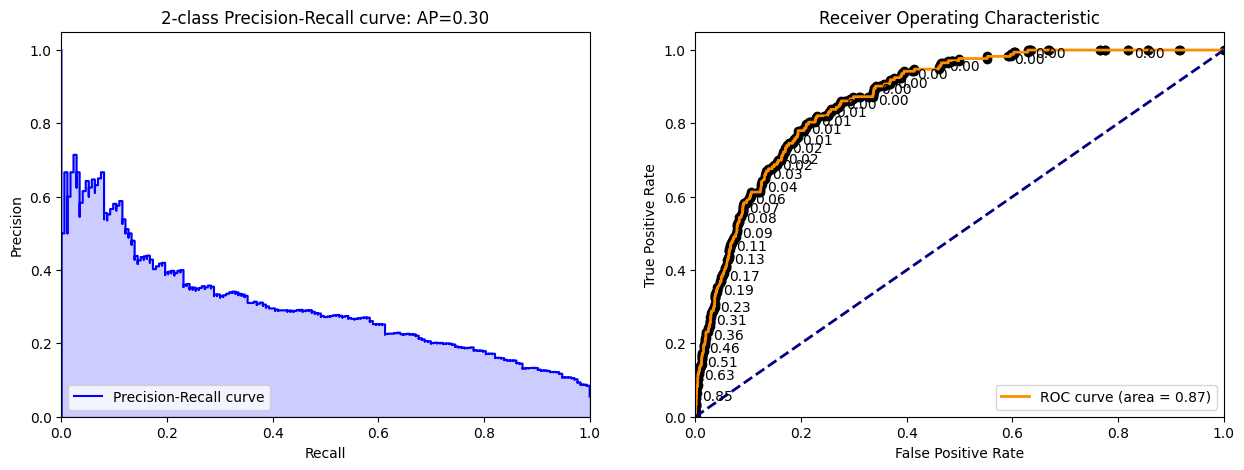

'\nROC curve: To correctly identifies ~100% of the true positives (cases where mosquitoes are infected), the model would \nincorrectly identifying >80% of the negatives as positives. For a TPR >80%, FPR would be >24% with a threshold <0.84%.\n'

In [171]:
### PLOT THE ROC AUC ###

# XGBClassifier was chosen. Close to best ROC AUC. Much higher Precision and Recall then LogisticRegression or AdaBoostClassifier.
default_models['XGBClassifier'].fit(X_train_o, y_train_o)
    
# Predict probabilities and classes
y_probs = default_models['XGBClassifier'].predict_proba(X_val_o)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, roc_thresholds = roc_curve(y_val_o, y_probs)
roc_auc = auc(fpr, tpr)

# Compute precision-recall pairs for different probability thresholds
precision, recall, pr_thresholds = precision_recall_curve(y_val_o, y_probs)
average_precision = average_precision_score(y_val_o, y_probs)

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.step(recall, precision, where='post', color='b', label='Precision-Recall curve')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'2-class Precision-Recall curve: AP={average_precision:.2f}')
plt.legend(loc="lower left")

# ROC curve plot
plt.subplot(1,2,2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr, tpr, marker='o', color='black')  # mark each threshold
for i, threshold in enumerate(roc_thresholds):
    if i % 11 == 0:
        plt.annotate(f"{threshold:.2f}", (fpr[i]+0.01, tpr[i]-0.02))  # annotate thresholds
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# for i, threshold in enumerate(roc_thresholds):
#     if tpr[i] > 0.8:
#         print(f"tpr: {tpr[i]:.4f} fpr: {fpr[i]:.4f} threshold: {threshold:.4f}")  # annotate thresholds
"""
ROC curve: To correctly identifies ~100% of the true positives (cases where mosquitoes are infected), the model would 
incorrectly identifying >80% of the negatives as positives. For a TPR >80%, FPR would be >24% with a threshold <0.84%.
"""

In [159]:
pd.DataFrame(default_models['XGBClassifier'].feature_importances_, index=X_val_o.columns).sort_values(by=0, ascending=False)

,0
Day_of_Year,0.10
WetBulb_lag1,0.04
Tavg_7day_avg,0.03
wnv_case_proportion,0.03
DewPoint_lag1,0.03
PrecipTotal,0.03
ResultDir_lag1,0.03
Tavg_lag1,0.03
PrecipTotal_7day_avg,0.03
NumMosquitos,0.03


In [ ]:
# Add random noise
noise_level = 0.01  # Adjust based on dataset scale
X_val_noisy = X_val_o + noise_level * np.random.normal(size=X_val_o.shape)

# Evaluate model on noisy data
ab_predictions_noisy = default_models['AdaBoostClassifier'].predict(X_val_noisy)
ab_f1_noisy = f1_score(y_val_o, ab_predictions_noisy)

print(f"F1 Score on Noisy Data: {ab_f1_noisy}")

In [ ]:
# Class-Specific Performance
from sklearn.metrics import classification_report

print(classification_report(y_val_o, ab_predictions))

Original dataset shape Counter({0: 6983, 1: 371})
Resampled dataset shape Counter({1: 6162, 0: 6005})
Resampled dataset shape Counter({0: 6062, 1: 2736})


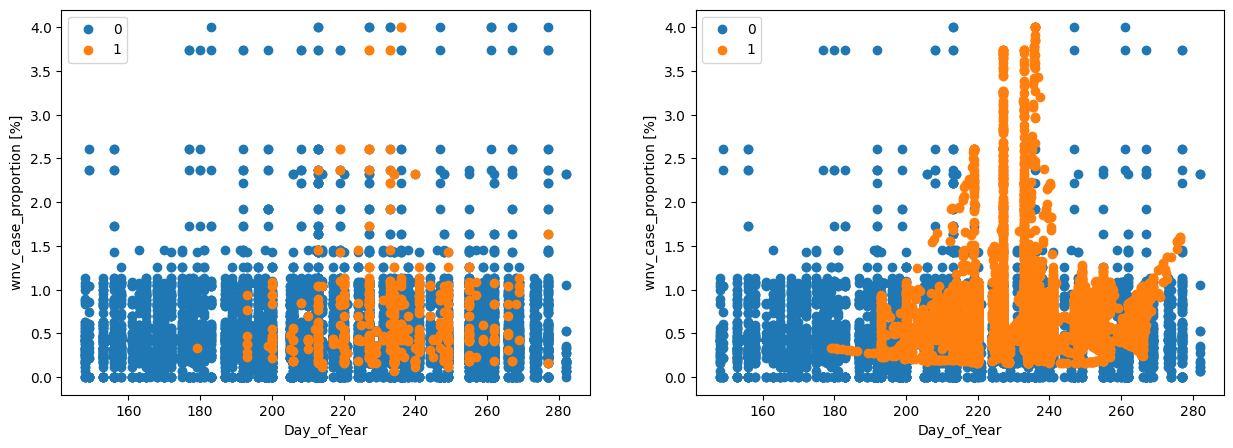

In [83]:
### BALANCED CLASSES ###

# Counting class distribution
class_counts = Counter(y_train_o)
print(f'Original dataset shape {class_counts}')

# SMOTEENN oversamples the minority class and undersamples the majority class
X_train_o_float = X_train_o.astype(float)
oversample = SMOTEENN(random_state=0)
X_resampled, y_resampled = oversample.fit_resample(X_train_o_float, y_train_o)

print(f'Resampled dataset shape {Counter(y_resampled)}')

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
for label in class_counts.keys():
    row_ix = np.where(y_train == label)[0]
    plt.scatter(X_train.loc[row_ix, 'Day_of_Year'], X_train.loc[row_ix, 'wnv_case_proportion'] * 100, label=str(label))
plt.xlabel("Day_of_Year")
plt.ylabel("wnv_case_proportion [%]")
plt.legend()

plt.subplot(1,2,2)
for label_resampled in class_counts.keys():
    row_ix_resampled = np.where(y_resampled == label_resampled)[0]
    plt.scatter(X_resampled.loc[row_ix_resampled, 'Day_of_Year'], X_resampled.loc[row_ix_resampled, 'wnv_case_proportion'] * 100, label=str(label_resampled))
plt.xlabel("Day_of_Year")
plt.ylabel("wnv_case_proportion [%]")
plt.legend()

plt.show()

In [79]:
### TEST 6 MODELS WITH DEFAULT HYPERPARAMETERS USING FULLY BALANCED (1:1) DATA ###

best_model_r = {
    'name': 'RandomForestClassifier',
    'model': RandomForestClassifier(),
    'score': 0.0
}

for name, dm in default_models.items():
    scores = cross_val_score(dm, X_resampled, y_resampled, cv=cv, scoring='roc_auc')
    score = np.mean(scores)
    if score > best_model_r['score']: 
        best_model_r['name'] = name
        best_model_r['model'] = dm
        best_model_r['score'] = score
    print(f"{name} Avg ROC AUC Score: {score:.3f}")

best_model_r['model'].fit(X_resampled, y_resampled)
ab_probs = best_model_r['model'].predict_proba(X_val_o)[:, 1]
ab_auc = roc_auc_score(y_val_o, ab_probs)
print(f"\nBest model: {best_model_r['name']}")
print(f"Validation Set ROC AUC Score: {ab_auc}")


RandomForestClassifier Avg ROC AUC Score: 0.999
XGBClassifier Avg ROC AUC Score: 0.999
LogisticRegression Avg ROC AUC Score: 0.939
GaussianNB Avg ROC AUC Score: 0.862
DecisionTreeClassifier Avg ROC AUC Score: 0.968
AdaBoostClassifier Avg ROC AUC Score: 0.979

Best model: RandomForestClassifier
Validation Set ROC AUC Score: 0.8292610662479437


In [126]:
X_train_remove_corrs, X_test_remove_corrs, y_train_remove_corrs, y_test_remove_corrs = train_test_split(X_train, y_train, test_size=.3)

# Initialize the classifier
model = xgb.XGBClassifier()

strat_kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, shuffle=True, random_state=42)

while X_train_remove_corrs.shape[1] > 1:  # Ensure at least one feature remains
    # Train the model
    scores = cross_val_score(model, X_train_remove_corrs, y_train_remove_corrs, cv=strat_kfold, scoring='roc_auc')
    print(f"\nAvg ROC AUC Score with current features: {np.mean(scores)}")
    
    # Fit model to get feature importances
    model.fit(X_train_remove_corrs, y_train_remove_corrs)

    model_probs = model.predict_proba(X_test_remove_corrs)[:, 1]  # get the probabilities for the positive class
    model_auc = roc_auc_score(y_test_remove_corrs, model_probs)
    print(f"XGBoost ROC AUC Score: {model_auc}")

    # Get feature importances and associated feature names
    feature_importances = pd.Series(model.feature_importances_, index=X_train_remove_corrs.columns)
    
    # Find the least important feature (minimum importance)
    least_important_feature = feature_importances.idxmin()
    
    # Remove the least important feature from X
    X_train_remove_corrs = X_train_remove_corrs.drop(columns=[least_important_feature])
    X_test_remove_corrs = X_test_remove_corrs.drop(columns=[least_important_feature])
    
    # Optionally check model performance and break if necessary
    # performance = evaluate_model(model, X, y)  # Assuming a function to evaluate model
    # if performance < threshold:
    #     break

    print(f"Removed feature: {least_important_feature}")
    print(f"Remaining features: {X_train_remove_corrs.columns.tolist()}")

print("Final set of features:", X_train_remove_corrs.columns)
# Optionally, retrain the final model here with X and y
model.fit(X_train_remove_corrs, y_train_remove_corrs)
model_probs = model.predict_proba(X_test_remove_corrs)[:, 1]  # get the probabilities for the positive class
model_auc = roc_auc_score(y_test_remove_corrs, model_probs)
print(f"\nXGBoost ROC AUC Score: {model_auc}")



Avg ROC AUC Score with current features: 0.8421227043001627
XGBoost ROC AUC Score: 0.867498123774401
Removed feature: Month
Remaining features: ['Species', 'Block', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'Day_of_Year', 'Week_of_Year', 'Day_of_Month', 'Day_of_Week', 'Location_Cluster', 'mosquito_proportion', 'wnv_case_proportion', 'wnv_case_proportion_alt', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Year', 'Tmax_lag1', 'Tmax_7day_avg', 'Tmin_lag1', 'Tmin_7day_avg', 'Tavg_lag1', 'Tavg_7day_avg', 'DewPoint_lag1', 'DewPoint_7day_avg', 'WetBulb_lag1', 'WetBulb_7day_avg', 'PrecipTotal_lag1', 'PrecipTotal_7day_avg', 'StnPressure_lag1', 'StnPressure_7day_avg', 'ResultSpeed_lag1', 'ResultSpeed_7day_avg', 'ResultDir_lag1', 'ResultDir_7day_avg', 'AvgSpeed_lag1', 'AvgSpeed_7day_avg']

Avg ROC AUC Score with current features:

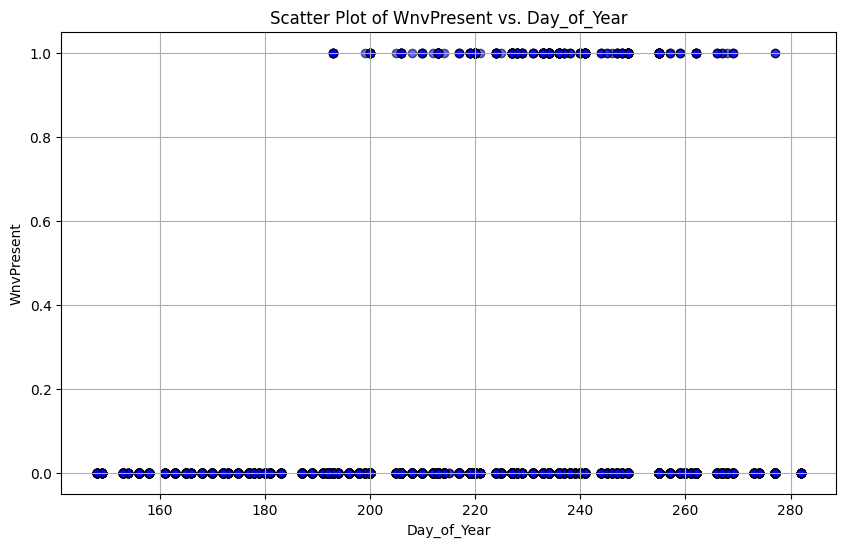

In [127]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train_remove_corrs, y_train_remove_corrs, color='blue', alpha=0.6, edgecolor='k')
plt.title(f"Scatter Plot of WnvPresent vs. Day_of_Year")
plt.xlabel(f"Day_of_Year")
plt.ylabel("WnvPresent")
plt.grid(True)
plt.show()

In [118]:
X_train_remove_corrs, X_test_remove_corrs, y_train_remove_corrs, y_test_remove_corrs = train_test_split(X_train, y_train, test_size=.3)

# Define a threshold for feature importance
importance_threshold = 0.01  # Define this based on your specific needs

# Initialize the classifier
model = xgb.XGBClassifier()

# Function to train model and remove features
def train_and_remove_features(X, y, X_test, y_test, model, threshold):
    # Train the model
    model.fit(X, y)
    
    # Get feature importances
    importances = model.feature_importances_
    
    # Get column names of features to keep (importance greater than threshold)
    features_to_keep = X.columns[importances > threshold]

    model_probs = model.predict_proba(X_test)[:, 1]  # get the probabilities for the positive class
    model_auc = roc_auc_score(y_test, model_probs)
    print(f"\nXGBoost ROC AUC Score: {model_auc}")

    # importances = model.feature_importances_
    # feature_names = X.columns
    # sorted_indices = np.argsort(importances)[::-1]

    # print("Feature importances:")
    # for idx in sorted_indices:
    #     print(f"{feature_names[idx]}: {importances[idx]:.4f}")

    # Filter DataFrame to keep these features only
    X_reduced = X[features_to_keep]
    
    return X_reduced, features_to_keep

# Iterate until condition met (no more features to remove or only one feature left)
while True:
    X_new, kept_features = train_and_remove_features(X_train_remove_corrs, y_train_remove_corrs, X_test_remove_corrs, y_test_remove_corrs , model, importance_threshold)
    if X_new.shape[1] == X_train_remove_corrs.shape[1] or X_new.shape[1] <= 1:  # Stop if no features are removed or only one remains
        break
    X_train_remove_corrs = X_new
    X_test_remove_corrs = X_test_remove_corrs[kept_features]
    

print("Final set of features:", X_train_remove_corrs.columns)
# Optionally, retrain the final model here with X and y
model.fit(X_train_remove_corrs, y_train_remove_corrs)
model_probs = model.predict_proba(X_test_remove_corrs[kept_features])[:, 1]  # get the probabilities for the positive class
model_auc = roc_auc_score(y_test_remove_corrs, model_probs)
print(f"XGBoost ROC AUC Score: {model_auc}")


XGBoost ROC AUC Score: 0.848864680815508
Feature importances:
Day_of_Year: 0.0870
DewPoint_lag1: 0.0524
WetBulb_lag1: 0.0460
wnv_case_proportion: 0.0390
Tmin: 0.0266
DewPoint: 0.0263
NumMosquitos: 0.0257
Tavg_7day_avg: 0.0245
Year: 0.0244
StnPressure_7day_avg: 0.0233
WetBulb_7day_avg: 0.0225
PrecipTotal_lag1: 0.0215
AvgSpeed_lag1: 0.0203
ResultSpeed_7day_avg: 0.0202
wnv_case_proportion_alt: 0.0199
PrecipTotal: 0.0198
AddressAccuracy: 0.0187
ResultSpeed_lag1: 0.0186
AvgSpeed_7day_avg: 0.0180
Tmax_lag1: 0.0178
SeaLevel: 0.0173
ResultSpeed: 0.0173
Day_of_Week: 0.0172
ResultDir: 0.0172
PrecipTotal_7day_avg: 0.0171
WetBulb: 0.0169
DewPoint_7day_avg: 0.0167
Week_of_Year: 0.0167
Tmax: 0.0164
Latitude: 0.0164
Tmin_7day_avg: 0.0160
Species: 0.0156
Tmax_7day_avg: 0.0156
Block: 0.0153
Trap: 0.0153
Longitude: 0.0152
Day_of_Month: 0.0151
StnPressure: 0.0148
Tmin_lag1: 0.0145
ResultDir_7day_avg: 0.0142
StnPressure_lag1: 0.0139
Location_Cluster: 0.0135
mosquito_proportion: 0.0135
ResultDir_lag1: 0.0

In [97]:

# orig_features = [feat for feat in numeric_df.columns if 'lag1' not in feat and '7day' not in feat]
# print(orig_features)
features_remove_corrs = ['Species', 'Block', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'Day_of_Year', 'Location_Cluster', 'mosquito_proportion', 'wnv_case_proportion', 'wnv_case_proportion_alt', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'Heat', 'PrecipTotal', 'StnPressure', 'ResultDir', 'AvgSpeed']
features_remove_corrs = ['Tmax', 'DewPoint']

X_train_subset = train_weather[features_remove_corrs]

X_train_remove_corrs, X_test_remove_corrs, y_train_remove_corrs, y_test_remove_corrs = train_test_split(X_train_subset, y_train, test_size=.3)

default_models = {
    'RandomForestClassifier':RandomForestClassifier(), 
    'XGBClassifier': xgb.XGBClassifier(), 
    'LogisticRegression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=100)),
    'GaussianNB': GaussianNB(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(algorithm='SAMME')
}
for model_key in default_models.keys():
    dmodel = default_models[model_key]
    dmodel.fit(X_train_remove_corrs, y_train_remove_corrs)
    dmodel_probs = dmodel.predict_proba(X_test_remove_corrs)[:, 1]  # get the probabilities for the positive class
    dmodel_auc = roc_auc_score(y_test_remove_corrs, dmodel_probs)
    print(f"{model_key} ROC AUC Score: {dmodel_auc}")

print(X_train_subset.head())

RandomForestClassifier ROC AUC Score: 0.810025875378371
XGBClassifier ROC AUC Score: 0.8128027213286486
LogisticRegression ROC AUC Score: 0.6121557387822681
GaussianNB ROC AUC Score: 0.5759400177733834
DecisionTreeClassifier ROC AUC Score: 0.8095560381441136
AdaBoostClassifier ROC AUC Score: 0.7278926377780524
   Tmax  DewPoint
0 88.00     58.50
1 88.00     58.50
2 88.00     58.50
3 88.00     58.50
4 88.00     58.50


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .......................max_depth=3, n_estimators=25; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=25; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=25; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=25; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=25; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ......................max_depth=3, n_es

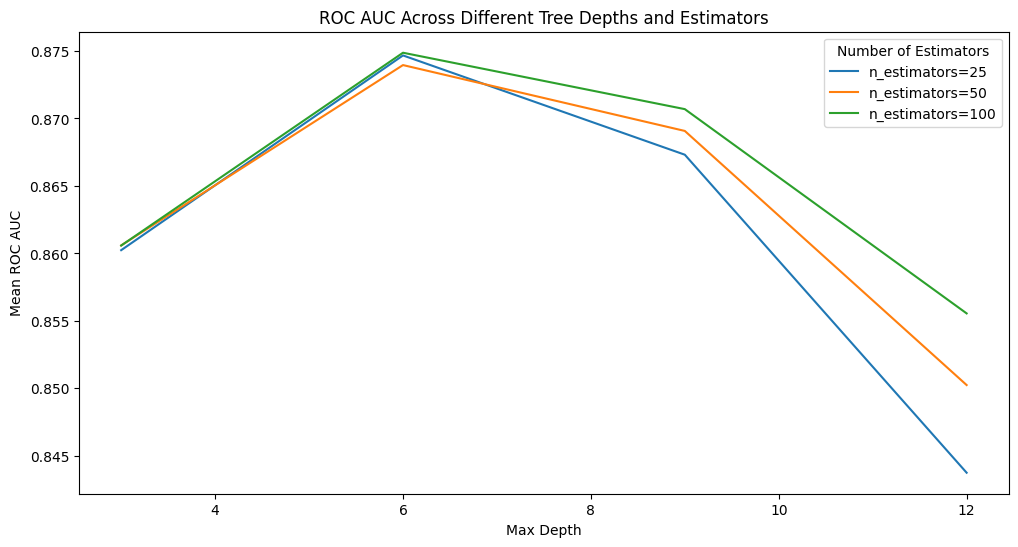

In [56]:
# Define the model
model = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [3, 6, 9, 12],
    # 'min_samples_split': [3, 6, 9]
}

cv = RepeatedStratifiedKFold(shuffle=True, n_splits=n_cross_validation)

# Setup the grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc', verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

results = pd.DataFrame(grid_search.cv_results_)

# Plotting each parameter's mean test score across CV folds
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for param, group in results.groupby('param_n_estimators'):
    group_mean_scores = group.mean_test_score
    ax.plot(group['param_max_depth'], group_mean_scores, label=f'n_estimators={param}')

ax.set_xlabel('Max Depth')
ax.set_ylabel('Mean ROC AUC')
ax.set_title('ROC AUC Across Different Tree Depths and Estimators')
ax.legend(title='Number of Estimators')
plt.show()

# Optionally, retrain or immediately use best_model for predictions
# predictions = best_model.predict(X_test)


In [57]:
# Assuming 'best_model' is the trained RandomForest model with the best parameters found
importances = best_model.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(importances)[::-1]

print("Feature importances:")
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")


Feature importances:
NumMosquitos: 0.1653
wnv_case_proportion_alt: 0.1020
Sunset: 0.0496
wnv_case_proportion: 0.0480
Day_of_Year: 0.0461
Longitude: 0.0385
Trap: 0.0352
Sunrise: 0.0347
Month: 0.0293
DewPoint_lag1: 0.0292
Week_of_Year: 0.0289
WetBulb_lag1: 0.0263
Latitude: 0.0262
mosquito_proportion: 0.0221
Year: 0.0217
WetBulb_7day_avg: 0.0163
Species: 0.0147
Block: 0.0125
Tmin_lag1: 0.0125
Location_Cluster: 0.0121
DewPoint_7day_avg: 0.0117
PrecipTotal_7day_avg: 0.0105
SeaLevel: 0.0100
StnPressure_7day_avg: 0.0099
PrecipTotal_lag1: 0.0099
Tavg: 0.0096
Tavg_7day_avg: 0.0093
Tmax_7day_avg: 0.0091
Cool: 0.0090
Day_of_Month: 0.0085
WetBulb: 0.0085
AvgSpeed_lag1: 0.0077
Tmin: 0.0075
StnPressure_lag1: 0.0075
Tmin_7day_avg: 0.0074
ResultSpeed_lag1: 0.0073
Tmax: 0.0073
ResultDir_lag1: 0.0068
AvgSpeed: 0.0065
DewPoint: 0.0061
ResultDir: 0.0061
AvgSpeed_7day_avg: 0.0061
StnPressure: 0.0059
Tmax_lag1: 0.0056
Tavg_lag1: 0.0056
ResultSpeed_7day_avg: 0.0052
ResultSpeed: 0.0050
AddressAccuracy: 0.0050

/usr/local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning:

The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=25; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=25; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=25; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=25; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=25; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_wei

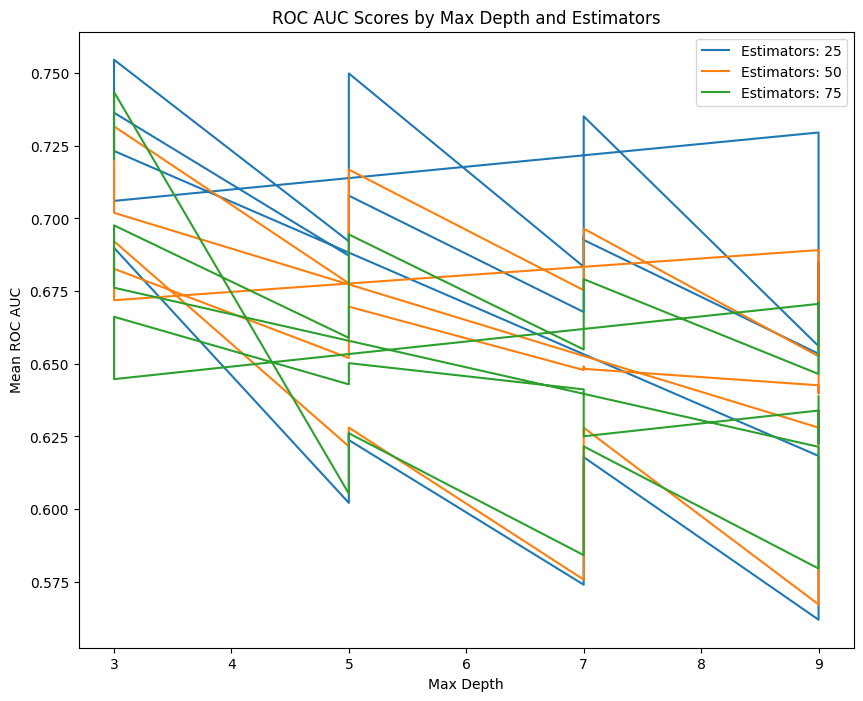

Feature importances:
NumMosquitos: 0.2001
Latitude: 0.1421
wnv_case_proportion_alt: 0.1131
Day_of_Year: 0.1086
DewPoint_lag1: 0.0979
wnv_case_proportion: 0.0923
StnPressure_lag1: 0.0651
WetBulb_lag1: 0.0386
Year: 0.0325
WetBulb_7day_avg: 0.0310
Tmax: 0.0267
StnPressure_7day_avg: 0.0243
DewPoint_7day_avg: 0.0152
ResultSpeed: 0.0096
ResultDir_lag1: 0.0026
AvgSpeed_lag1: 0.0002
AvgSpeed: 0.0001
Day_of_Month: 0.0001
Tmin: 0.0000
mosquito_proportion: 0.0000
Tavg: 0.0000
AvgSpeed_7day_avg: 0.0000
Week_of_Year: 0.0000
Location_Cluster: 0.0000
Day_of_Week: 0.0000
Month: 0.0000
DewPoint: 0.0000
AddressAccuracy: 0.0000
Longitude: 0.0000
Trap: 0.0000
Block: 0.0000
Depart: 0.0000
SnowFall: 0.0000
WetBulb: 0.0000
Tmin_lag1: 0.0000
ResultDir_7day_avg: 0.0000
ResultSpeed_7day_avg: 0.0000
ResultSpeed_lag1: 0.0000
PrecipTotal_7day_avg: 0.0000
PrecipTotal_lag1: 0.0000
Tavg_7day_avg: 0.0000
Tavg_lag1: 0.0000
Tmin_7day_avg: 0.0000
Tmax_7day_avg: 0.0000
Heat: 0.0000
Tmax_lag1: 0.0000
ResultDir: 0.0000
SeaL

In [37]:
param_grid = {
    'max_depth': [3, 5, 7, 9],  # Depth of each tree
    'min_child_weight': [1, 5, 10],  # Minimum sum of instance weight (hessian) needed in a child
    'n_estimators': [25, 50, 75],  # Number of trees
    'learning_rate': [0.01, 0.1, 0.2]  # Step size shrinkage used to prevent overfitting
}

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring=roc_auc, cv=n_cross_validation, verbose=2)

# Fitting GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Printing the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score found: ", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Convert GridSearchCV results into a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plotting each parameter's mean test score
plt.figure(figsize=(10, 8))
for i in results['param_n_estimators'].unique():
    subset = results[results['param_n_estimators'] == i]
    plt.plot(subset['param_max_depth'], subset['mean_test_score'], label=f'Estimators: {i}')

plt.xlabel('Max Depth')
plt.ylabel('Mean ROC AUC')
plt.title('ROC AUC Scores by Max Depth and Estimators')
plt.legend()
plt.show()

# Assuming 'best_model' is the trained RandomForest model with the best parameters found
importances = best_model.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(importances)[::-1]

print("Feature importances:")
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")

In [ ]:
# # Define the path to the SQLite database
# database_path = os.path.join('/app/data', 'west_nile_virus.db')

# # Connect to an SQLite database and write the DataFrame
# with sqlite3.connect(database_path) as conn:
#     try:
#         # Export cleaned data to SQLite
#         train.to_sql('train_cleaned', con=conn, index=False, if_exists='replace')
#         test.to_sql('test_cleaned', con=conn, index=False, if_exists='replace')
#         weather.to_sql('weather_cleaned', con=conn, index=False, if_exists='replace')
#         print("Data Inserted Successfully")
        
#         # Confirm data insertion
#         query_result = pd.read_sql_query("SELECT * FROM ads_kpi_dashboard", conn)
#         print("Confirm Data Insertion")
#         print(query_result)
#     except Exception as e:
#         print("Error in database operation:", e)